In [1]:
using Base.Threads
println("Number of threads: ", nthreads())


# To set threads for paralel chains go to command prompt 
# see how many threads are available on the CPU with:
# "wmic cpu get NumberOfLogicalProcessors"
# Set the number of threads you want to use with:
# "set JULIA_NUM_THREADS=6 (6 as an example)"
# Then open julia with threads in vs code with:
# "code ."


Number of threads: 1


In [2]:
using Revise  # auto reload

includet("State_Space_Model.jl")
using .state_space_model

includet("Kalman.jl")
using .kalman

includet("MCMC.jl")
using .MCMC

includet("Particle.jl")
using .ParticleFilter

includet("model_specs.jl")
using .ModelSpecs



using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions
using Plots
using StatsPlots
using CSV
using DataFrames
using BenchmarkTools 

using MCMCChains  # For diagnostics
using ArviZ


## Model & Priors

In [3]:
model = "wave cycle stochastic drift no noise"

θ_elements, α_elements, prior_info_collection, θ_true = get_model_info(model)
n_chains = length(prior_info_collection)


1

## Data

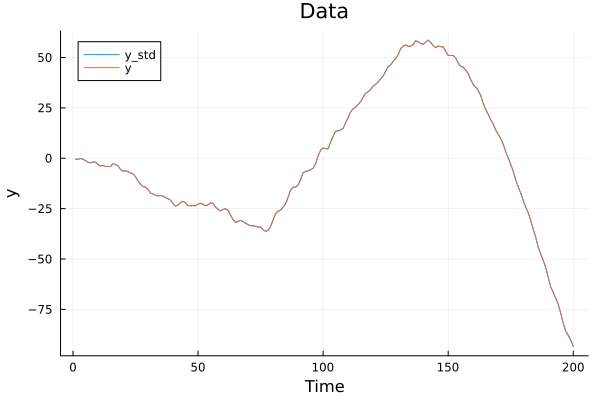

4×4 Matrix{Float64}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

In [4]:
simulate = true
standardize = false

if simulate
    n_obs = 200
    y, α = simulate_data(model, θ_true, n_obs)
    y_std, σʸ = standardize_data(y)
    if standardize == false
        y_std = y
        σʸ = 1.0
    end
    
    

else
    # Load data 
    data = CSV.read("data.csv", DataFrame)
    y = data.y
    y = Matrix(y')
    # log transform y
    y = log.(y)
    println(size(y))
    y_std, σʸ = standardize_data(y)
    if standardize == false
        y_std = y
        σʸ = 1.0
    end
    n_obs = length(y)
end


# plot data
plot(y_std[1,:], label="y_std", title="Standardized data", xlabel="Time", ylabel="y", legend=:topleft)
plot!(y[1,:], label="y", title="Data", xlabel="Time", ylabel="y", legend=:topleft)
display(plot!())

# Initial states
α0 = zeros(length(α_elements))
α0[1] = y_std[1]
P0 = 1*Matrix{Float64}(I, length(α_elements), length(α_elements))

In [5]:
# if simulate

#     n_particles_values = [500, 1000, 2000]
#     num_runs = 20  

#     mean_times = zeros(length(n_particles_values))
#     mean_logL = zeros(length(n_particles_values))
#     std_logL = zeros(length(n_particles_values))

#     # Loop over each particle count
#     for (idx, n_particles) in enumerate(n_particles_values)
#         logL_runs = zeros(num_runs)
#         time_runs = zeros(num_runs)
#         for run in 1:num_runs
#             # Measure the execution time with @elapsed
#             t = @elapsed begin
#                 log_L_particle, _ = particle_filter(model, y_std, θ_true, α0, P0, σʸ, N_particles=n_particles)
#             end
#             time_runs[run] = t
#             logL_runs[run] = log_L_particle
#         end
#         mean_times[idx] = mean(time_runs)
#         mean_logL[idx] = mean(logL_runs)
#         std_logL[idx] = std(logL_runs)
#         println("Particles: ", n_particles, 
#                 " | Mean log likelihood: ", mean_logL[idx],
#                 " | Std log likelihood: ", std_logL[idx],
#                 " | Mean time: ", mean_times[idx])
#     end

#     # Plot execution time vs. number of particles
#     p_time = plot(n_particles_values, mean_times,
#                   marker=:o,
#                   xlabel="Number of Particles",
#                   ylabel="Mean Execution Time (s)",
#                   title="Execution Time vs. Number of Particles",
#                   legend=false)

#     # Plot standard deviation of log likelihood vs. number of particles
#     p_logL = plot(n_particles_values, std_logL,
#                   marker=:o,
#                   xlabel="Number of Particles",
#                   ylabel="Std of Log Likelihood",
#                   title="Log Likelihood Variability vs. Number of Particles",
#                   legend=false)

#     display(p_time)
#     display(p_logL)

#     #Run and print the Kalman filter results
#     Log_L_kalman, states_kalman, _ = diffuse_kalman_filter(model, y_std, θ_true, α0, P0, σʸ, true, false)
#     println("Log likelihood kalman filter: ", Log_L_kalman)

#     # Plot the state trajectories from the particle and Kalman filters
#     log_L_particle, states_particle = particle_filter(model,y_std, θ_true, α0, P0,σʸ, N_particles=1000)
#     for i in 1:length(α_elements)
#         p = plot(states_particle[i, :].*σʸ, label="particle", title=α_elements[i],
#                  xlabel="Time", ylabel=α_elements[i], legend=:topleft)
#         plot!(p, states_kalman[i, :].*σʸ, label="kalman")
#         plot!(p, α[i, :], label="true")
#         display(p)
#     end
# end


## MCMC

In [6]:
# θ_chain_all, θ_chain_init_all, α_draws_all = MCMC_estimation_parallel(y_std, prior_info_collection, α0, P0, cycle_order, σʸ;
#                                    filter_type="kalman",
#                                    iter_init=10000,
#                                    burn_init=5000,
#                                    iter_rec=10000,
#                                    burn_rec=5000,
#                                    ω=1.0,
#                                    target_low=0.25,
#                                    target_high=0.35,
#                                    n_chains=n_chains)


In [7]:
cycle_order = 1
θ_chain_all, θ_chain_init_all, α_draws_all = MCMC_estimation(model, y_std, prior_info_collection, α0, P0, σʸ;
filter_type = "kalman",
iter_init = 20000, 
burn_init = 10000,
 iter_rec = 20000,
burn_rec = 10000,
N_particles = 1000,
ω = 0.05,
n_chains = n_chains)

println(size(θ_chain_all))
println(size(α_draws_all))



Starting chain 1 ...
Chain 1, Initial Parameters: [0.9450058087553302, 0.5652075940316199, 4.562475923294479, 0.9533743688037138]


Initialization Phase (chain 1) 100%|█████████████████████| Time: 0:00:13


Chain 1, Initialization Acceptance Rate: 29.65%


Recursion Phase (chain 1) 100%|██████████████████████████| Time: 0:00:13


Chain 1, Recursion Acceptance Rate: 31.155%
Chain 1 completed in 26.557000160217285 seconds.
(10000, 4, 1)
(10000, 4, 200, 1)


Chains MCMC chain (20000×4×1 Array{Float64, 3}):

Iterations        = 1:1:20000
Number of chains  = 1
Samples per chain = 20000
parameters        = ρ, λ, σ_ξ, σ_κ

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           ρ    0.9038    0.0248    0.0018    189.6567    294.3974    1.0015   ⋯
           λ    1.0433    0.0453    0.0018   1256.5019   2072.0214    1.0012   ⋯
         σ_ξ    0.0925    0.0905    0.0037    212.1009    419.1401    1.0057   ⋯
         σ_κ    0.1148    0.0330    0.0014    318.2013    843.7364    1.0005   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           ρ    0.8549    0.8871    0.9045    0.9214    0.9486
           λ    0.9784    1.0249    1.0453    

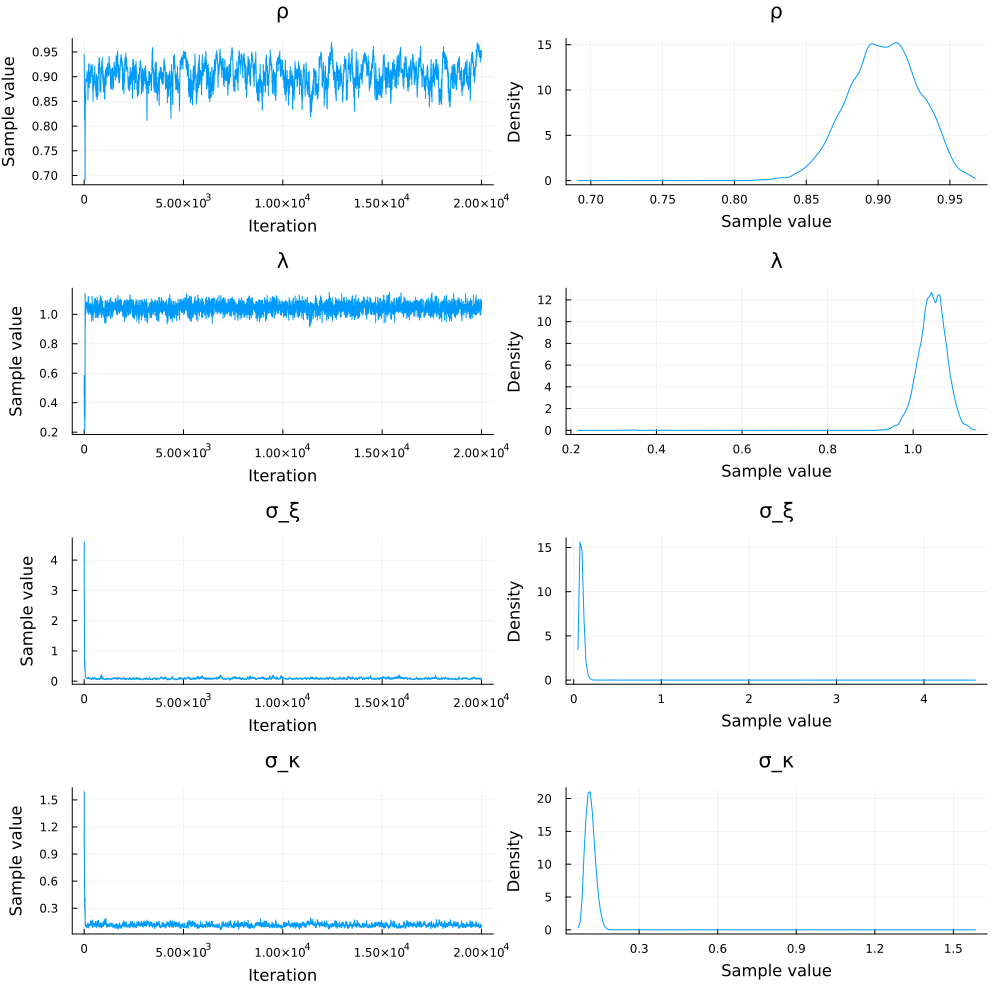

In [8]:
chain_init = Chains(θ_chain_init_all, θ_elements)
display(chain_init)
plot(chain_init)

Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
parameters        = ρ, λ, σ_ξ, σ_κ

Summary Statistics
  parameters      mean       std      mcse   ess_bulk    ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64    Float64     Float64   Float64    ⋯

           ρ    0.9075    0.0229    0.0008   801.0259   1009.3116    1.0029    ⋯
           λ    1.0456    0.0301    0.0011   714.2813    967.7704    1.0007    ⋯
         σ_ξ    0.0895    0.0227    0.0009   603.2239   1020.9855    1.0027    ⋯
         σ_κ    0.1120    0.0178    0.0007   578.3454    885.9662    1.0011    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           ρ    0.8600    0.8930    0.9084    0.9235    0.9491
           λ    0.9830    1.0271    1.0474    

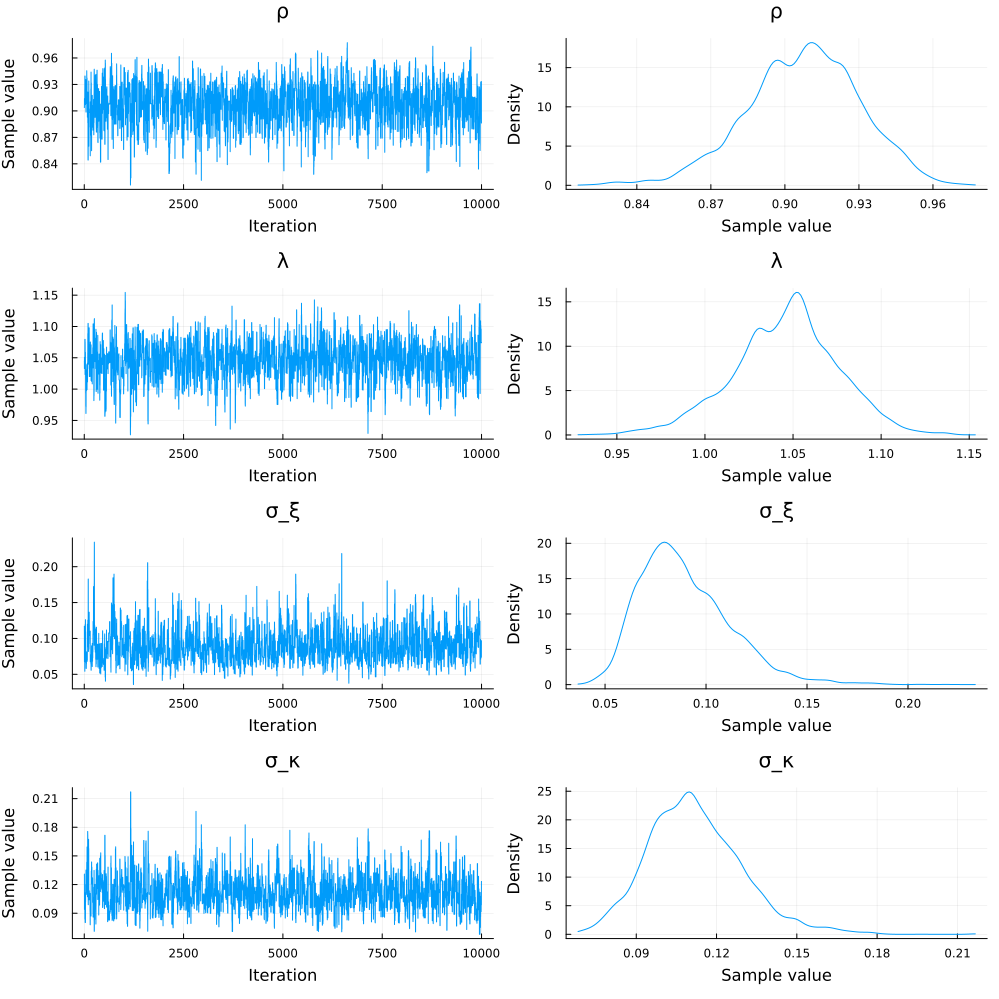

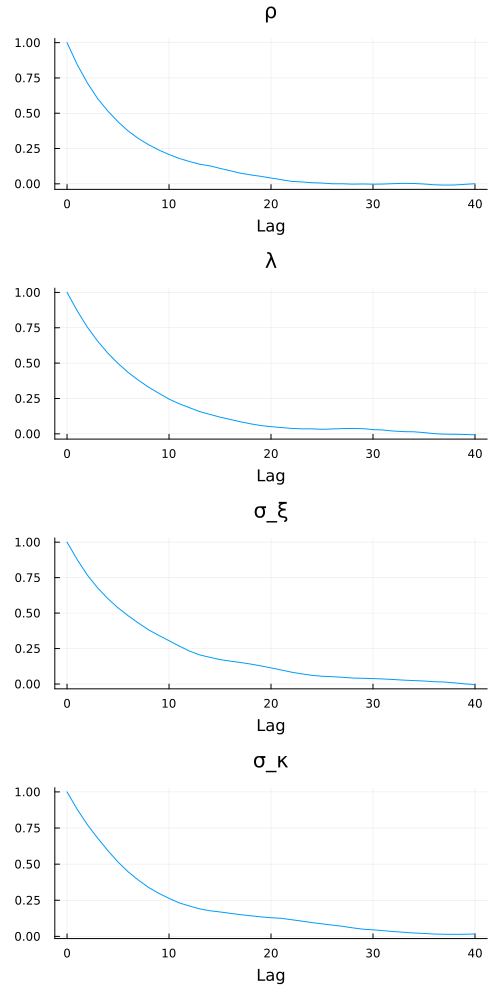

In [9]:

chain_rec = Chains(θ_chain_all, θ_elements)
display(chain_rec)

display(plot(chain_rec))
# display(corner(chain_rec))
display(autocorplot(chain_rec))

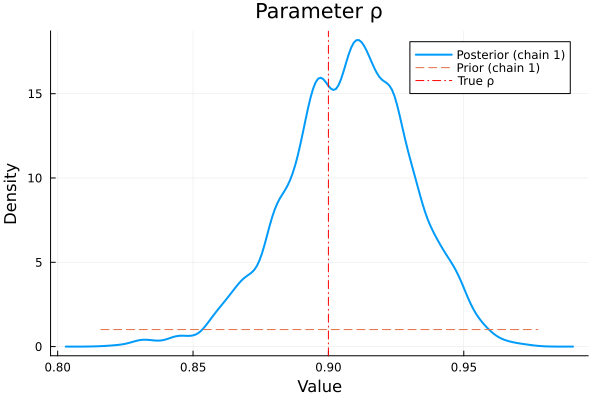

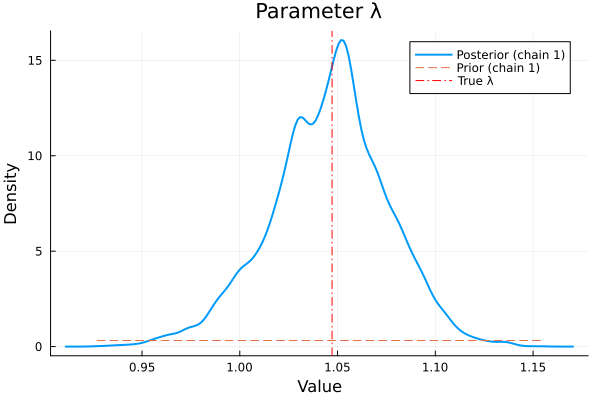

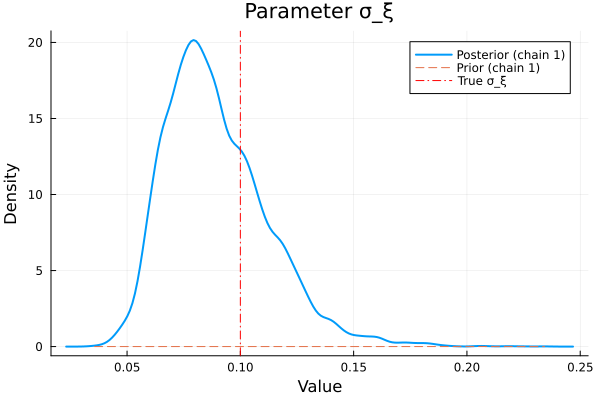

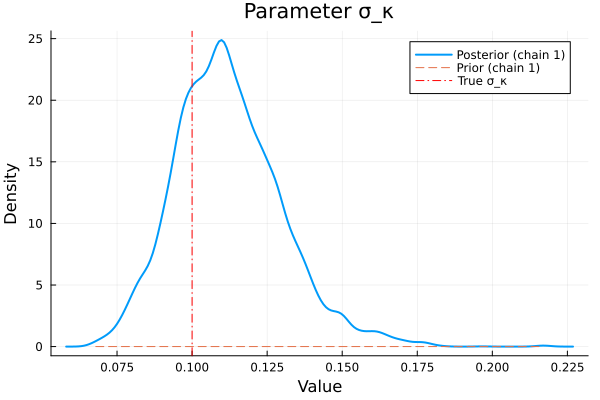

4-element Vector{Float64}:
 0.9
 1.0471975511965976
 0.1
 0.1

In [10]:

for i in 1:size(θ_chain_all, 2)
    p = plot(title = "Parameter $(θ_elements[i])", xlabel = "Value", ylabel = "Density")
    
    # For each chain, plot the chain-specific posterior density
    for j in 1:n_chains
        samples = θ_chain_all[:, i, j]
        density!(p, samples, label = "Posterior (chain $j)", linewidth = 2)
    end
    
    # for each chain, overlay the prior density (using a dashed line)
    for j in 1:n_chains
        dist_type = prior_info_collection[j].distributions[i]
        hp1 = prior_info_collection[j].parameters[i, 1]
        hp2 = prior_info_collection[j].parameters[i, 2]
        if dist_type == "uniform"
            prior = Uniform(hp1, hp2)
        elseif dist_type == "beta"
            prior = Beta(hp1, hp2)
        elseif dist_type == "normal"
            prior = Normal(hp1, hp2)
        elseif dist_type == "inverse_gamma"
            prior = InverseGamma(hp1, hp2)
        else
            error("Unknown prior distribution: $dist_type")
        end
        samples = θ_chain_all[:, i, j]
        x_min = minimum(samples)
        x_max = maximum(samples)
        xs = range(x_min, x_max, length = 200)
        # Plot the prior density using a dashed line style
        plot!(p, xs, pdf.(prior, xs), label = "Prior (chain $j)", linestyle = :dash)
    end

    # If simulation is used, add the true value
    if simulate
        vline!(p, [θ_true[i]], label = "True $(θ_elements[i])", linestyle = :dashdot, color = :red)
    end

    display(p)
end

display(θ_true)


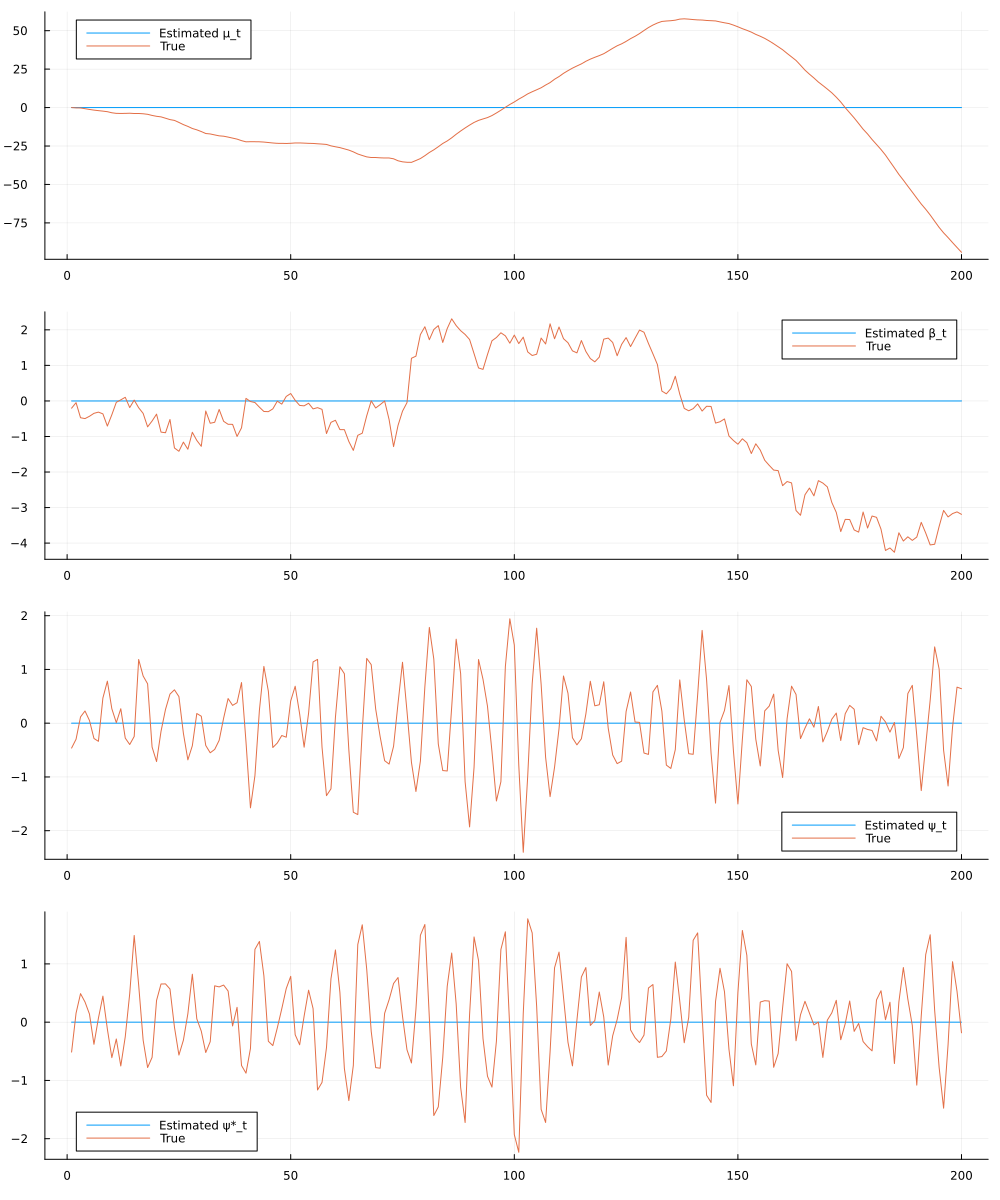

In [11]:
# α_draws_all has shape (iter_rec, state_dim, obs, n_chains)
n_chains = size(α_draws_all, 4)
n_states = size(α_draws_all, 2)


plots_vec = []
for i in 1:n_states
    for ch in 1:n_chains
        # Extract draws for the current chain 
        α_draws = α_draws_all[:,:,:,ch].*σʸ
    
        # Compute the mean over iterations (dimension 1) 
        α_mean = dropdims(mean(α_draws, dims=1), dims=1)
    
        # Compute the 2.5% and 97.5% quantiles over iterations.
        α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_draws, dims=1)
    
        p = plot(α_mean[i, :],
                 ribbon = (α_ci[2, i, :] .- α_mean[i, :]),
                 label = "Estimated $(α_elements[i])")
        if simulate
            plot!(p, α[i, :], label = "True")
        end
        push!(plots_vec, p)
    end
end

combined_plot = plot(plots_vec..., layout = (n_states, n_chains), size=(1000, 300*n_states))
display(combined_plot)


## MLE

In [12]:
# using Optim

# θ_init = θ_true

# lower_bounds = prior_info_collection[1].support[:, 1]
# upper_bounds = prior_info_collection[1].support[:, 2]
# objective(θ) = neg_log_likelihood(θ, model, y_std, α0, P0, σʸ)
# result = optimize(objective, lower_bounds, upper_bounds, θ_init, Fminbox(LBFGS()))
# θ_est = Optim.minimizer(result)

# println("Estimated parameters: ", θ_est)
# println("True parameters: ", θ_true)

